In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

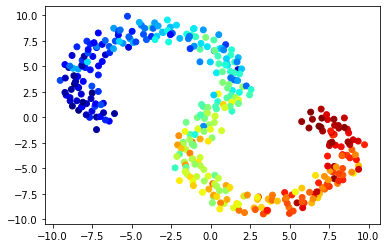

In [2]:
#Task 2: Denoising on irregular graph (S-shaped 2D points)
xy_value_noise = torch.load('graph_s_data_pytorch.pth')

x = xy_value_noise['x']
y = xy_value_noise['y']
val_noise = xy_value_noise['values']

n = len(val_noise)

cm = plt.cm.get_cmap('jet')
order_noise = torch.zeros(n)
order_noise[torch.sort(val_noise)[1]] = torch.linspace(0,1,n)
plt.scatter(x,y,c=order_noise.numpy(),vmin=0,vmax=1,s=35,cmap=cm)
plt.show()


In [3]:
xy = torch.stack([x,y] ,1)

distance = ((xy.unsqueeze(1) - xy.unsqueeze(0))**2).sum(2)

val, idx = torch.topk(input=distance, k=17, dim=1, largest=False, sorted=True)

idx2 = torch.arange(distance.size(1)).unsqueeze(1)
idx2 = idx2.repeat(1, 17)

idx_neighbors = torch.stack((idx2, idx), dim=0).view(2,-1)

weights = - torch.exp(-2 * val)
weights = weights.flatten()

mat = torch.sparse_coo_tensor(indices=idx_neighbors, values=weights, size=(n, n)).to_dense()


# fill diagonal 
mat.fill_diagonal_(0)
idx_diag = torch.arange(distance.size(1))
idx_diag = torch.stack((idx_diag, idx_diag), dim=0)

val_diag = - (mat.sum(dim=1))

mat_diag = torch.sparse_coo_tensor(indices=idx_diag, values=val_diag, size=(n,n)).to_dense() 

mat += mat_diag
mat *= 25
mat += torch.eye(n,n)

val_new = torch.linalg.solve(input=mat, other=val_noise.reshape(-1, 1))


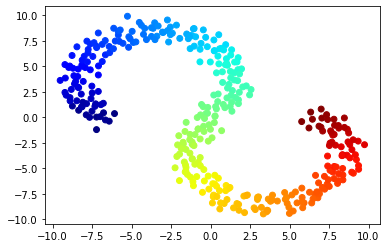

In [4]:
#read in result from libtorch processing
#value_denoise = torch.load('graph_s_output.pth')
value_denoise = val_new.squeeze()

order_denoise = torch.zeros(n)
order_denoise[torch.sort(value_denoise)[1]] = torch.linspace(0,1,n)
plt.scatter(x,y,c=order_denoise.numpy(),vmin=0,vmax=1,s=35,cmap=cm)
plt.show()